# 1.0 Importing Libraries

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', 50)

# 2.0 Loading Data

In [4]:
df_sales_group = pd.read_csv('dataset/sales_group.csv')

author = pd.read_csv('dataset/author.csv')
award = pd.read_csv('dataset/award.csv')
book = pd.read_csv('dataset/book.csv')
edition = pd.read_csv('dataset/edition.csv')
format = pd.read_csv('dataset/format.csv')
genders = pd.read_csv('dataset/genders.csv')
info = pd.read_csv('dataset/info.csv')
publisher = pd.read_csv('dataset/publisher.csv')
ratings = pd.read_csv('dataset/ratings.csv')
series = pd.read_csv('dataset/series.csv')

### 2.1 Basic Data Transformation

In [5]:
# Renaming the columns on the award dataset to eliminate spaces
cols_new = ['book_id', 'title', 'award_name', 'year_won']
award.columns = cols_new

In [6]:
# Checking for duplicates
datasets = [author, award, book, edition, format, info, publisher, series, genders, ratings]
datasets_names = ['author', 'award', 'book', 'edition', 'format', 'info', 'publisher', 'series', 'genders', 'ratings']

i=0
for dataset in datasets:
    print(f'Dataset: {datasets_names[i]} - Quantidade de duplicadas: {dataset.duplicated().sum()}\n')
    i+=1

Dataset: author - Quantidade de duplicadas: 0

Dataset: award - Quantidade de duplicadas: 0

Dataset: book - Quantidade de duplicadas: 0

Dataset: edition - Quantidade de duplicadas: 0

Dataset: format - Quantidade de duplicadas: 0

Dataset: info - Quantidade de duplicadas: 0

Dataset: publisher - Quantidade de duplicadas: 119

Dataset: series - Quantidade de duplicadas: 0

Dataset: genders - Quantidade de duplicadas: 0

Dataset: ratings - Quantidade de duplicadas: 0



In [7]:
# Lets remove the duplicates from the publisher dataset
publisher.drop_duplicates(inplace=True)

### 2.2 Merging the datasets

In [8]:
df = pd.merge(book, author, how='left', on='author_id')
df = pd.merge(df, info, how='left', on='book_id')
df = pd.merge(df, series, how='left', on='series_id')
df = pd.merge(df, genders, how='left', on='genre_id')

#### 2.2.1 Award dataset

The award dataset has duplicated book_ids for books with multiple awards, lets aggregate them before merging

In [9]:
award_agg = award.groupby('book_id').agg({
    'title': 'first',
    'award_name': lambda x: ', '.join(x),
    'year_won': 'first'}).reset_index()

df = pd.merge(df, award_agg, how='left', on='book_id')

#### 2.2.2 Publisher dataset

The publisher dataset also has duplicated book_ids for books with multiple publishers. But, we have a problem that some publishers have two different pub_ids, so we can't merge them yet.

So, first we'll determine that the right pub_id is the one who corresponds to the initials of the publisher name.


In [10]:
# Defining useful functions

def get_initials(name):
    return "".join(word[0] for word in name.split()).upper()

def select_pub_id(group):
    initials = group["initials"].iloc[0]
    matching_pub_id = group[group["pub_id"] == initials]

    if not matching_pub_id.empty:
        return matching_pub_id.iloc[0]
    else:
        return group.sort_values("pub_id").iloc[0]


In [11]:
# Getting the initials of the publisher name
publisher["initials"] = publisher["name"].apply(get_initials)

# Selecting the correct pub_id
publisher_corrected = publisher.groupby(["book_id", "name"], group_keys=False).apply(select_pub_id)
publisher_corrected.reset_index(drop=True, inplace=True)

# Dropping the initial column
publisher_corrected = publisher_corrected.drop(columns=["initials"])
publisher = publisher.drop(columns=["initials"])

Now we can aggregate and merge the datasets.

Here, we'll opt for summing the marketing spend, since it's the corresponding value for each book

In [12]:
# Aggregating the publisher dataset
publisher_agg = publisher_corrected.groupby('book_id').agg({
    'name': lambda x: ', '.join(x),
    'city': lambda x: ', '.join(x),
    'state': 'first',
    'country': 'first',
    'year_established': 'first',
    'marketing_spend': 'sum',
    'pub_id': lambda x: ', '.join(x)
}).reset_index()

In [13]:
# Merging the datasets
df = pd.merge(df, publisher_agg, how='left', on='book_id')

#### 2.2.3 Ratings dataset

Let's keep only the average rating and the number of ratings for each book

In [14]:
# Getting the average rating
ratings_mean = ratings.groupby('book_id')['rating'].mean().round(2).reset_index()
ratings_mean.columns = ['book_id', 'rating_mean']

In [15]:
# Getting the number of ratings
ratings_count = ratings.groupby('book_id')['rating'].count().reset_index()
ratings_count.columns = ['book_id', 'rating_count']

In [16]:
# Merging the datasets
df = pd.merge(df, ratings_mean, how='left', on='book_id')
df = pd.merge(df, ratings_count, how='left', on='book_id')

#### 2.2.4 Edition dataset

Lets first merge the edition and the format datasets.

In [17]:
df_edition = pd.merge(edition, format, how='left', on='format_id')

In [18]:
df_edition.drop(columns=['format_id'], inplace=True)

#### 2.2.5 Sales dataset

In [19]:
sales = pd.merge(df_sales_group, df_edition, how='left', on='isbn')
# sales = pd.merge(sales, df, how='left', on=['book_id', 'pub_id'])

# 3.0 Data Transformation

Lets organize the data before merging into the sales dataset

In [20]:
# Getting the author name
df['author_name'] = df['first_name'] + ' ' + df['last_name']

## 3.1 Dataset columns

In [21]:
# Remove unuseful columns
df.drop(columns=['title_y', 'author_id', 'genre_id', 'series_id', 'first_name', 'last_name'], inplace=True)

In [22]:
# Renaming the columns
df.rename(columns={
    'title_x': 'title',
    'genre_desc': 'genre',
    'name': 'pub_name',
    'city': 'pub_city',
    'state': 'pub_state',
    'country': 'pub_country'
}, inplace=True)

In [23]:
sales.rename(columns={
    'COUNT': 'sales_count',
    'format_desc': 'format'
}, inplace=True)

## 3.2 Data types

In [24]:
# Checking the data types
df.dtypes

book_id               object
title                 object
birthday              object
country_residence     object
hrs_writing_day      float64
volume_number        float64
series_name           object
genre                 object
award_name            object
year_won             float64
pub_name              object
pub_city              object
pub_state             object
pub_country           object
year_established     float64
marketing_spend      float64
pub_id                object
rating_mean          float64
rating_count         float64
author_name           object
dtype: object

In [25]:
sales.dtypes

sale_date            object
isbn                 object
sales_count           int64
book_id              object
pub_id               object
publication_date     object
pages                 int64
print_run_size_k      int64
price               float64
format               object
dtype: object

In [26]:
# Transform from object to datetime
df['birthday'] = pd.to_datetime(df['birthday'], format='%d/%m/%Y')
sales['sale_date'] = pd.to_datetime(sales['sale_date'], format='%d/%m/%Y')
sales['publication_date'] = pd.to_datetime(sales['publication_date'], format='%d/%m/%Y')

In [27]:
# Transform from float to int
df['volume_number'] = df['volume_number'].astype('Int64')
df['year_won'] = df['year_won'].astype('Int64')
df['year_established'] = df['year_established'].astype('Int64')
df['marketing_spend'] = df['marketing_spend'].astype('Int64')
df['rating_count'] = df['rating_count'].astype('Int64')
sales['print_run_size_k'] = sales['print_run_size_k'].astype('Int64')
sales['pages'] = sales['pages'].astype('Int64')

## 3.3 Null values

In [28]:
# Checking for missing values
df.isnull().sum()

book_id               0
title                 0
birthday              0
country_residence     0
hrs_writing_day       0
volume_number        38
series_name          38
genre                 0
award_name           41
year_won             41
pub_name              1
pub_city              1
pub_state             1
pub_country           1
year_established      1
marketing_spend       1
pub_id                1
rating_mean           2
rating_count          2
author_name           0
dtype: int64

In [29]:
sales.isnull().sum()

sale_date           0
isbn                0
sales_count         0
book_id             0
pub_id              0
publication_date    0
pages               0
print_run_size_k    0
price               0
format              0
dtype: int64

In [30]:
# volume_number null values are the ones that don't have series
df['volume_number'].fillna(0, inplace=True)

# series_name null values are the ones that also don't have series
df['series_name'].fillna('', inplace=True)

# award_name and year_won null values are the ones that don't have awards, so let's keep them as NaN

# rating_count null values are the ones that don't have ratings
df['rating_count'].fillna(0, inplace=True)

# We have one book that doesn't have a publisher
# Let's keep the rating_mean null value as NaN to not affect the average rating


## 3.4 Check duplicates

In [31]:
df.duplicated().sum()

0

In [32]:
df['book_id'].duplicated().sum()

0

In [33]:
sales.duplicated().sum()

0

## 3.5 Creating sales by date per book dataset

In [34]:
print(f'The df dataset has information about {df.shape[0]} books and the following {df.shape[1]} columns:\n{list(i for i in df.columns)}')

The df dataset has information about 58 books and the following 20 columns:
['book_id', 'title', 'birthday', 'country_residence', 'hrs_writing_day', 'volume_number', 'series_name', 'genre', 'award_name', 'year_won', 'pub_name', 'pub_city', 'pub_state', 'pub_country', 'year_established', 'marketing_spend', 'pub_id', 'rating_mean', 'rating_count', 'author_name']


In [35]:
print(f'The sales dataset has information about {sales.shape[0]} sales and the following {sales.shape[1]} columns:\n{list(i for i in sales.columns)}')

The sales dataset has information about 15188 sales and the following 10 columns:
['sale_date', 'isbn', 'sales_count', 'book_id', 'pub_id', 'publication_date', 'pages', 'print_run_size_k', 'price', 'format']


Now we can finally merge the two datasets.

In [36]:
df_sales = pd.merge(sales, df, how='left', on=['book_id', 'pub_id'])

## 3.6 Creating sales per book dataset

In [37]:
# Create dataset with the total sales for each book
sales_per_book = df_sales.groupby('isbn').agg(total_sales=('sales_count', 'sum')).reset_index()

In [38]:
# Create dataset with the books info
book_info = df_sales.drop(columns=['sale_date', 'sales_count']).drop_duplicates()

In [39]:
# Merge the two datasets
sales_total = pd.merge(sales_per_book, book_info, how='left', on='isbn')

In [40]:
# Create a column for the total revenue for each book
sales_total['total_revenue'] = sales_total['total_sales'] * sales_total['price']

# 4.0 Exploratory Data Analysis

## 4.1 Analysing big numbers

Total invoice

In [41]:
value_to_display = sales_total['total_revenue'].sum()

# Convert value to thousands and format as USD
value_in_k = value_to_display / 1_000

In [42]:
# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_in_k,
    title={"text": "Total Invoice"},
    number={"prefix": "USD ", "suffix": "K", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart
fig.show()

Total sales

In [43]:
value_to_display = sales_total['total_sales'].sum()

# Convert value to thousands
value_in_k = value_to_display / 1_000

# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_in_k,
    title={"text": "Total Sales Count"},
    number={"prefix": "", "suffix": "K", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart    
fig.show()

Number of unique book titles

In [44]:
value_to_display = sales_total['title'].nunique()

# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_to_display,
    title={"text": "Unique Book Titles"},
    number={"prefix": "", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling 
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart
fig.show()

## 4.2 Overview

In [45]:
from plot_utils import create_horizontal_bar_plot, create_vertical_bar_plot, create_box_plot

### 4.2.1 Genre distribution

In [46]:
create_vertical_bar_plot(sales_total, 'genre')

### 4.2.2 Publisher distribution

In [47]:
create_vertical_bar_plot(sales_total, 'pub_name', 'Publisher distribution')

We note that there are only 4 publishers in the dataset and the one with the highest amount of books is Etaoin Shrdlu Press (ESP)

### 4.2.3 Format distribution

In [48]:
create_horizontal_bar_plot(sales_total, 'format')

The most common book format is Hardcover.

### 4.2.4 Author distribution

In [49]:
create_horizontal_bar_plot(sales_total, 'author_name', 'Books per author distribution')

### 4.2.5 Price distribution

In [50]:
price_distribution = sales_total.price.describe()

In [51]:
print(f'The average price of a book is ${price_distribution["mean"]:.2f} and the standard deviation is ${price_distribution["std"]:.2f}')
print(f'The minimum price is ${price_distribution["min"]:.2f} and the maximum price is ${price_distribution["max"]:.2f}')

The average price of a book is $16.84 and the standard deviation is $8.47
The minimum price is $5.99 and the maximum price is $48.00


In [52]:
create_box_plot(sales_total, 'price')

We have only one outlier with a price of $48.

### 4.2.6 Pages distribution

In [53]:
pages_distribution = sales_total.pages.describe()
print(f'The average number of pages is {pages_distribution["mean"].round(0)} and the standard deviation is {pages_distribution["std"]:.2f}')
print(f'The minimum number of pages is {pages_distribution["min"].round(0)} and the maximum number of pages is {pages_distribution["max"].round(0)}')

The average number of pages is 387.0 and the standard deviation is 252.85
The minimum number of pages is 11.0 and the maximum number of pages is 1296.0


In [54]:
create_box_plot(sales_total, 'pages')

### 4.2.7 Geographical distribution

In [55]:
create_horizontal_bar_plot(sales_total, 'country_residence', "Author's country of residence distribution")

In [56]:
# Let's plot the country distribution for the publishers in the dataset
df_plot = sales_total.groupby('pub_country').agg(
    Count=('pub_country', 'count'),
    Publishers=('pub_name', lambda x: ", ".join(sorted(set(x))))
).reset_index()

df_plot.columns = ['pub_country'.replace('_', ' ').title(), 'Count', 'Publishers']
df_plot = df_plot.sort_values('Count', ascending=False)

fig = px.bar(
    df_plot,
    x=df_plot.columns[0],
    y=df_plot.columns[1],
    text=df_plot["Publishers"],
    title=f"Publisher's country distribution",
    color_discrete_sequence=['seagreen']
)

fig.update_traces(textposition="outside")
fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    xaxis_title=df_plot.columns[0],
    yaxis_title='Count',
    height=600,
    width=800
)

fig.show()

## 4.3 Top Sellers

In [57]:
from plot_utils import create_horizontal_high_value_bar_plot, create_vertical_high_value_bar_plot, create_vertical_high_value_bar_plot_normalized

### 4.3.2 Best-selling and most profitable books

In [58]:
create_horizontal_high_value_bar_plot(sales_total, 'title', 'total_sales', quantile=0.9)

In [59]:
create_horizontal_high_value_bar_plot(sales_total, 'title', 'total_revenue', quantile=0.9)

We see that our top 3 🏆 Best-selling books are:

1. The Mallemaroking
2. Rystwyth
3. Heliotrope Pajamas

And our 💵 Most Profitable books are:

1. Rystwyth
2. The Mallemaroking
3. Portmeirion

### 4.3.3 Most Profitable Authors

In [60]:
create_horizontal_high_value_bar_plot(sales_total, 'author_name', 'total_revenue')

In [61]:
books_from_bianca = sales_total[sales_total['author_name'] == 'Bianca Thompson']['title'].unique()
print(f'Our most profitable author is Bianca Thompson and her books are: {books_from_bianca}')

Our most profitable author is Bianca Thompson and her books are: ['The Mallemaroking' 'Portmeirion' 'Rystwyth']


### 4.3.4 Most profitable genres

In [62]:
from plot_utils import create_vertical_high_value_bar_line_plot

In [63]:
create_vertical_high_value_bar_line_plot(sales_total, 'genre', 'total_sales')

Childrens book have a higher percentage of sales in relation to the quantity offered than those in the SciFi/Fantasy genre (our top-seller)

In [64]:
create_vertical_high_value_bar_line_plot(sales_total, 'genre', 'total_revenue')

### 4.3.5 Most profitable format

In [65]:
create_vertical_high_value_bar_line_plot(sales_total, 'format', 'total_sales', legend_pos=[0.95, 0.85])

Here, we see that the Board Books have a higher sales rate than the Mass Market Paperback ones. Since this book format is more common in children's books, we can invest in increasing the stock of children's books.

### 4.3.6 Most profitable publishers

In [66]:
create_vertical_high_value_bar_line_plot(sales_total, 'pub_name', 'total_revenue')

In [67]:
create_vertical_high_value_bar_line_plot(sales_total, 'pub_name', 'total_sales')

## 4.4 Hypothesis

### 4.4.1 Correlation beetween good reviews and total sales

In [68]:
# First, lets analyse the ratings distribution
create_box_plot(sales_total, 'rating_mean')

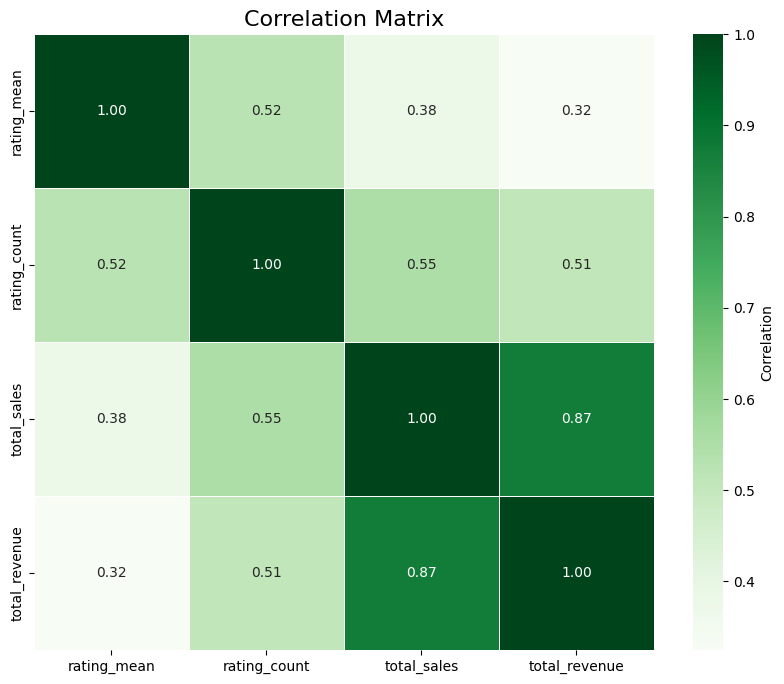

In [69]:
# Now, lets see the correlation between the ratings and the sales
correlation_matrix = sales_total[['rating_mean', 'rating_count', 'total_sales', 'total_revenue']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='Greens',
    cbar_kws={'label':'Correlation'},
    linewidths=0.5
)

plt.title('Correlation Matrix', fontsize=16)
plt.show()

Here we see that rating_mean has a high correlation with both total_sales and total_revenue. Futhermore, we see that rating_count has an even stronger correlation.

Let's analyse books that have a high rating but a low invoice.

In [70]:
from plot_utils import plot_top_quartile_and_sales

df_ratings = sales_total.groupby('title', as_index=False).agg({
    'rating_mean': 'mean',
    'rating_count': 'sum',
    'total_sales': 'sum',
    'total_revenue': 'sum'
}
)

In [71]:
plot_top_quartile_and_sales(df_ratings, 'total_sales', 'rating_mean')

Here we can see that some books have a high rating but a low invoice. We can make some specific promotions to increase their selling rate.

### 4.4.2 Correlation between prizes won and total sales

In [117]:
sales_total['award_winner'] = sales_total['award_name'].notnull().astype(int)

In [168]:
# Lets plot a pizza chart to see how many books won awards

awards_count = sales_total['award_winner'].value_counts().reset_index()
awards_count['award_winner'] = awards_count['award_winner'].map({0: 'No', 1: 'Yes'})

fig = px.pie(
    values=awards_count['count'],
    names=awards_count['award_winner'],
    title='Award Winners Distribution',
    template='plotly_white',
    color=awards_count['award_winner'],
    color_discrete_map={'No': 'seagreen', 'Yes': 'yellowgreen'}
)

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    height=600,
    width=600,
    legend_title_text='Award Winner'
)

fig.show()

In [ ]:
# Now lets plot a bar chart for the average income for books that won awards

awards_count = sales_total.groupby('award_winner').agg({'total_revenue': 'mean'}).reset_index()
awards_count['award_winner'] = awards_count['award_winner'].map({0: 'No', 1: 'Yes'})

fig = px.bar(
    awards_count,
    x='award_winner',
    y='total_revenue',
    title='Average Revenue for Award Winners and Non-Winner Books',
    template='plotly_white',
    color='award_winner',
    color_discrete_map={'No': 'seagreen', 'Yes': 'yellowgreen'},
    text_auto='.3s'
)

fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    xaxis_title='Award Winner',
    yaxis_title='Average Revenue',
    height=600,
    width=800,
    showlegend=False
)

fig.show()

# Tests

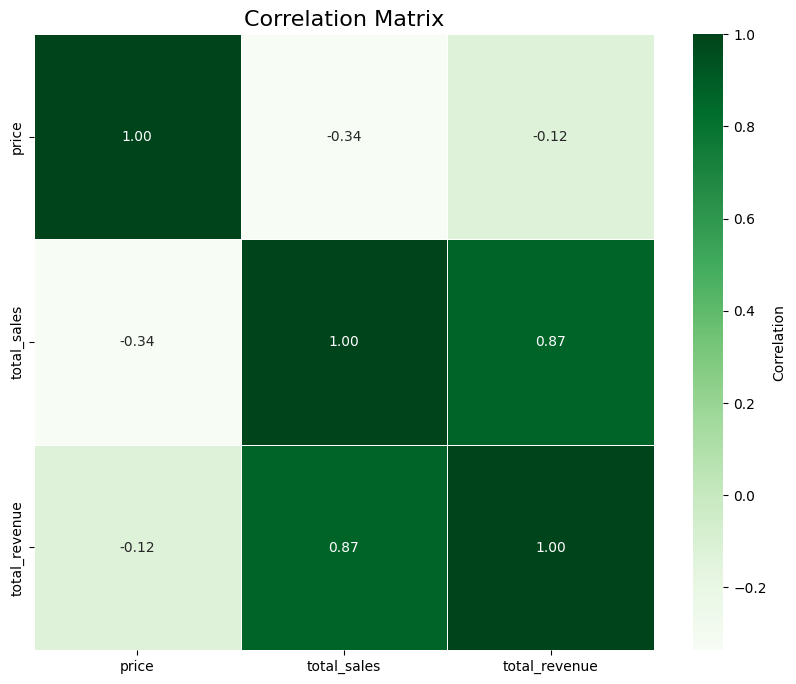

In [92]:
# Now, lets see the correlation between the ratings and the sales
correlation_matrix = sales_total[['price', 'total_sales', 'total_revenue']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='Greens',
    cbar_kws={'label':'Correlation'},
    linewidths=0.5
)

plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [96]:
import statsmodels.api as sm
import numpy as np

In [97]:
test = sales_total.copy()
test['log_price'] = np.log(test['price'])
test['log_sales'] = np.log(test['total_sales'])

In [100]:
X = sm.add_constant(test['log_price'])
model = sm.OLS(test['log_sales'], X).fit()
elasticidade = model.params['log_price']

print(f'Elaticidade: {elasticidade:.2f}')

Elaticidade: -1.91


In [105]:
descontos = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

resultados = []
for d in descontos:
    test['new_price'] = test['price'] * (1 - d)
    test['new_sales'] = test['total_sales']* (1+elasticidade*(-d))

    test['new_total_revenue'] = test['new_price'] * test['new_sales']

    receita_atual = test['total_revenue'].sum()
    receita_com_desconto = test['new_total_revenue'].sum()
    ganho_percentual = (receita_com_desconto - receita_atual) / receita_atual * 100

    resultados.append((d, receita_atual.round(2), receita_com_desconto.round(2), ganho_percentual.round(2)))


resultados_df = pd.DataFrame(resultados, columns=['Desconto', 'Receita atual', 'Receita com desconto', 'Ganho percentual (%)'])
resultados_df

,Desconto,Receita atual,Receita com desconto,Ganho percentual (%)
0,0.05,699885.48,728394.52,4.07
1,0.10,699885.48,750219.00,7.19
2,0.15,699885.48,765358.92,9.35
3,0.20,699885.48,773814.28,10.56
4,0.25,699885.48,775585.08,10.82
5,0.30,699885.48,770671.33,10.11
6,0.40,699885.48,740790.13,5.84
7,0.50,699885.48,684170.71,-2.25
8,0.60,699885.48,600813.04,-14.16
9,0.70,699885.48,490717.13,-29.89
